# Comparison to Luc Simard's catalogue

This notebook reads in files created elsewhere containing galaxy builder models (aggregate, best individual and optimized best individual) and compares them to Simard (2011).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from gzbuilder_analysis.fitting.jupyter import UpdatableDisplay
from IPython.display import HTML

Read in the required files:

In [29]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
aggregation_results = pd.read_pickle('lib/aggregation_results.pickle')
best_models = pd.read_pickle('lib/best_individual.pickle')
fitted_models = pd.read_pickle('lib/fitted_models.pickle')

Initalise rendering Model objects for all the different kinds of model

In [4]:
def make_model(subject_id, m):
  psf = gu.get_psf(subject_id)
  diff_data = gu.get_diff_data(subject_id)
  pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
  galaxy_data = np.array(diff_data['imageData'])[::-1]
  return fitting.Model(m, galaxy_data, psf=psf, pixel_mask=pixel_mask)

In [5]:
bi_models = pd.Series([]).rename('Models')
with tqdm(
  best_models['Model'].dropna().items(),
  total=len(best_models),
  desc='{: <25}'.format('Best individual')
) as bar:
  for i, model in bar:
    bi_models[i] = make_model(i, model)
      
fitted_bi_models = pd.Series([]).rename('Models')
with tqdm(
  fitted_models['fitted_bi_models'].dropna().items(),
  total=len(fitted_models['fitted_bi_models'].dropna()),
  desc='{: <25}'.format('Fitted best individual')
) as bar:
  for i, model in bar:
    fitted_bi_models[i] = make_model(i, model)

fitted_agg_models = pd.Series([]).rename('Models')
with tqdm(
  fitted_models['fitted_agg_models'].dropna().items(),
  total=len(fitted_models['fitted_agg_models'].dropna()),
  desc='{: <25}'.format('Aggregate')
) as bar:
  for i, model in bar:
    fitted_agg_models[i] = make_model(i, model)

Aggregate                : 100%|██████████| 234/234 [01:16<00:00,  6.35it/s]


Get a couple of measures of fit to use for dissecting the result

In [6]:
def get_bulge_n(m):
  return m['bulge'].get('n', np.nan) if m['bulge'] is not None else np.nan

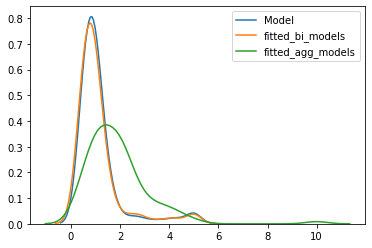

In [7]:
sns.kdeplot(best_models['Model'].dropna().apply(get_bulge_n).dropna())
sns.kdeplot(fitted_models['fitted_bi_models'].dropna().apply(get_bulge_n).dropna())
sns.kdeplot(fitted_models['fitted_agg_models'].dropna().apply(get_bulge_n).dropna())

In [17]:
def get_model_to_data(model):
  r_total = model.cached_render(model._model).sum()
  d = model.data.sum() * 0.8
  if d == 0:
    return np.nan
  return r_total / d

def get_bulge_to_total(model):
  # get the total flux in the bulge vs the total flux in the galaxy model
  model.cached_render(model._model)
  r_total = model.cache.sum()
  r_bulge = model.cache[[1, 2]].sum()
  if r_total == 0:
    return np.nan
  return r_bulge / r_total

def get_score(model):
  return fitting.loss(
    model.cached_render(model._model),
    model.data,
    model.pixel_mask
  )

Calculate the ratio of light in the input image to that in the model

In [9]:
model_ratios = pd.concat((
  bi_models.apply(get_model_to_data).rename('bi_model_ratio'),
  fitted_bi_models.apply(get_model_to_data).rename('fitted_bi_model_ratio'),
  fitted_agg_models.apply(get_model_to_data).rename('agg_model_ratio'),
), axis=1)

Calculate the bulge / total fractions

In [10]:
b_t = pd.concat((
  bi_models.apply(get_bulge_to_total).rename('bi_b_t'),
  fitted_bi_models.apply(get_bulge_to_total).rename('fitted_b_t'),
  fitted_agg_models.apply(get_bulge_to_total).rename('agg_b_t'),
), axis=1)

Calculate the model's MSE scores

In [18]:
scores = pd.concat((
  bi_models.apply(get_score).rename('bi_scores'),
  fitted_bi_models.apply(get_score).rename('fitted_bi_scores'),
  fitted_agg_models.apply(get_score).rename('agg_scores'),
), axis=1)

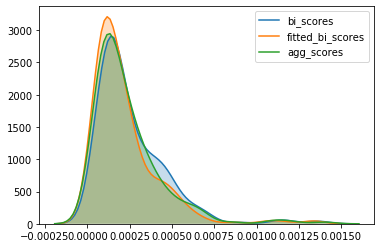

In [19]:
for col in scores.columns:
  sns.kdeplot(scores[col].dropna(), shade=True)

## Results

Make Series of bulge/total and bar/total ratios

In [13]:
nspirals = fitted_agg_models.apply(lambda m: len(m['spiral'])).rename('nspirals')
has_bar = fitted_agg_models.apply(lambda m: int(m['bar'] is not None)).rename('has_bar')

In [90]:
comp_df = pd.concat((
  b_t,
#   scores,
#   model_ratios,
  nspirals,
  has_bar,
  simard_df['__B_T_r'].rename('SIMARD'),
  simard_df_free['__B_T_r'].rename('SIMARD_FREE')
), axis=1)

In [235]:
comp_df.head(2)

,bi_b_t,fitted_b_t,agg_b_t,nspirals,has_bar,SIMARD,SIMARD_FREE
20901989,0.227603,0.228617,0.216037,0.0,1.0,0.55,0.47
20901990,0.024033,0.014960,0.000000,3.0,0.0,0.02,0.62


In [92]:
comp_df[['bi_b_t', 'fitted_b_t', 'agg_b_t', 'SIMARD', 'SIMARD_FREE']].corr()

,bi_b_t,fitted_b_t,agg_b_t,SIMARD,SIMARD_FREE
bi_b_t,1.000000,0.924698,0.368451,0.488148,0.077419
fitted_b_t,0.924698,1.000000,0.455304,0.491279,0.051254
agg_b_t,0.368451,0.455304,1.000000,0.376896,0.089733
SIMARD,0.488148,0.491279,0.376896,1.000000,0.127029
SIMARD_FREE,0.077419,0.051254,0.089733,0.127029,1.000000



For Simard 4 + 1 vs n + 1 
N-arms:  0, N-points:  85, 𝝆:  0.25063, P(uncorrelated): 0.02148
N-arms:  1, N-points:  46, 𝝆:  0.00014, P(uncorrelated): 0.99928
N-arms:  2, N-points:  84, 𝝆:  0.11639, P(uncorrelated): 0.30077
N-arms:  3, N-points:  17, 𝝆: -0.25961, P(uncorrelated): 0.33155
N-arms:  4, N-points:   2, 𝝆:  1.00000, P(uncorrelated): 1.00000
All,        N-points:   2, 𝝆:  0.17903, P(uncorrelated): 0.00660

For fitted Best Individual classification
N-arms:  0, N-points:  85, 𝝆:  0.67838, P(uncorrelated): 0.00000
N-arms:  1, N-points:  46, 𝝆:  0.25792, P(uncorrelated): 0.08353
N-arms:  2, N-points:  84, 𝝆:  0.28005, P(uncorrelated): 0.01134
N-arms:  3, N-points:  17, 𝝆:  0.67686, P(uncorrelated): 0.00398
N-arms:  4, N-points:   2, 𝝆:  1.00000, P(uncorrelated): 1.00000

For Aggregate model
N-arms:  0, N-points:  85, 𝝆:  0.28638, P(uncorrelated): 0.00827
N-arms:  1, N-points:  46, 𝝆:  0.49768, P(uncorrelated): 0.00043
N-arms:  2, N-points:  84, 𝝆:  0.43457, P(uncorrelated): 0.0000

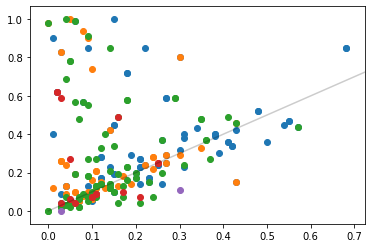

In [237]:
c = comp_df.dropna()
print('\nFor Simard 4 + 1 vs n + 1')
for n in np.unique(c['nspirals']):
  _m = comp_df['nspirals'] == n
  plt.scatter(comp_df['SIMARD'][_m], comp_df['SIMARD_FREE'][_m])
  print(
    'N-arms: {:^ 1n}, N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
      n, len(comp_df[_m]),
      *st.pearsonr(c['SIMARD'][_m], c['SIMARD_FREE'][_m])
    )
  )
print(
  'All,        N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
    len(comp_df[_m]),
    *st.pearsonr(c['SIMARD'], c['SIMARD_FREE'])
  )
)
plt.gca().add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))

print('\nFor fitted Best Individual classification')
for n in np.unique(c['nspirals']):
  _m = comp_df['nspirals'] == n
  print(
    'N-arms: {:^ 1n}, N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
      n, len(comp_df[_m]),
      *st.pearsonr(c['SIMARD'][_m], c['fitted_b_t'][_m])
    )
  )
print('\nFor Aggregate model')
for n in np.unique(c['nspirals']):
  _m = comp_df['nspirals'] == n
  print(
    'N-arms: {:^ 1n}, N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
      n, len(comp_df[_m]),
      *st.pearsonr(c['SIMARD'][_m], c['agg_b_t'][_m])
    )
  )
None

In [179]:
c = comp_df.dropna()
print('For fitted Best Individual classification')
for n in np.unique(c['nspirals']):
  _m = comp_df['nspirals'] == n
  print(
    'N-arms: {:^ 1n}, N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
      n, len(comp_df[_m]),
      *st.pearsonr(c['SIMARD'][_m], c['fitted_b_t'][_m])
    )
  )
print('\nFor Aggregate model')
for n in np.unique(c['nspirals']):
  _m = comp_df['nspirals'] == n
  print(
    'N-arms: {:^ 1n}, N-points: {:> 3}, 𝝆: {:> 7.5f}, P(uncorrelated): {:.5f}'.format(
      n, len(comp_df[_m]),
      *st.pearsonr(c['SIMARD'][_m], c['agg_b_t'][_m])
    )
  )
None

For fitted Best Individual classification
N-arms:  0, N-points:  85, 𝝆:  0.67838, P(uncorrelated): 0.00000
N-arms:  1, N-points:  46, 𝝆:  0.25792, P(uncorrelated): 0.08353
N-arms:  2, N-points:  84, 𝝆:  0.28005, P(uncorrelated): 0.01134
N-arms:  3, N-points:  17, 𝝆:  0.67686, P(uncorrelated): 0.00398
N-arms:  4, N-points:   2, 𝝆:  1.00000, P(uncorrelated): 1.00000

For Aggregate model
N-arms:  0, N-points:  85, 𝝆:  0.28638, P(uncorrelated): 0.00827
N-arms:  1, N-points:  46, 𝝆:  0.49768, P(uncorrelated): 0.00043
N-arms:  2, N-points:  84, 𝝆:  0.43457, P(uncorrelated): 0.00005
N-arms:  3, N-points:  17, 𝝆:  0.70949, P(uncorrelated): 0.00208
N-arms:  4, N-points:   2, 𝝆: -1.00000, P(uncorrelated): 1.00000


In [94]:
m = comp_df['has_bar'].astype(bool)
titles = ('Best individual classification', 'Fitted best individual classification', 'Aggregate') 
cols = ('bi_b_t', 'fitted_b_t', 'agg_b_t')

In [224]:
bulge_disk_model_mask = simard_df['PpS'] < 0.32

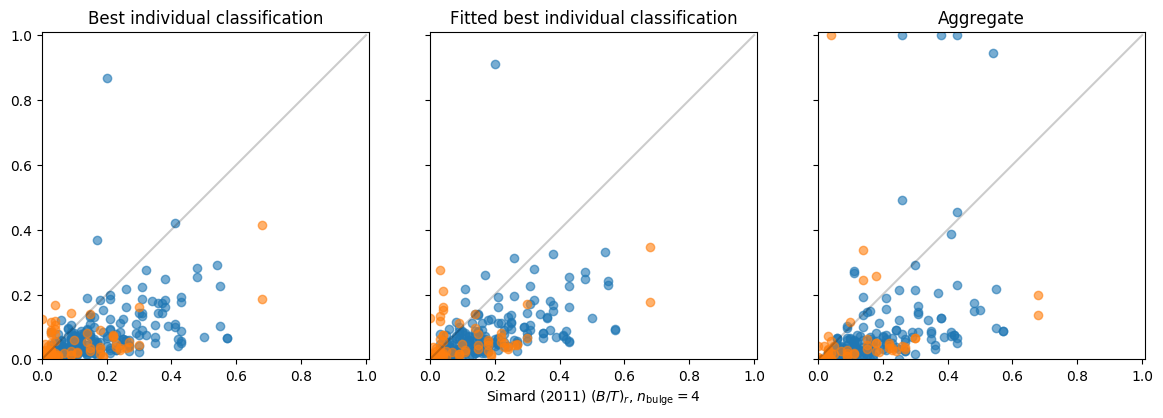

In [225]:
_, ax = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(12, 4), dpi=100)
for i, col in enumerate(cols):
  ax[i].scatter(
    comp_df['SIMARD'], comp_df[col], marker='o',
    alpha=0.6,
  )
  ax[i].set_xlim(0, 1.01)
  ax[i].set_ylim(0, 1.01)
  ax[i].add_line(plt.Line2D(*[[0, 1]]*2, color='k', alpha=0.2))
  ax[i].set_aspect('equal')
  ax[i].set_title(titles[i])
ax[1].set_xlabel('Simard (2011) $(B/T)_r$, $n_\mathrm{bulge}=4$')
plt.tight_layout()

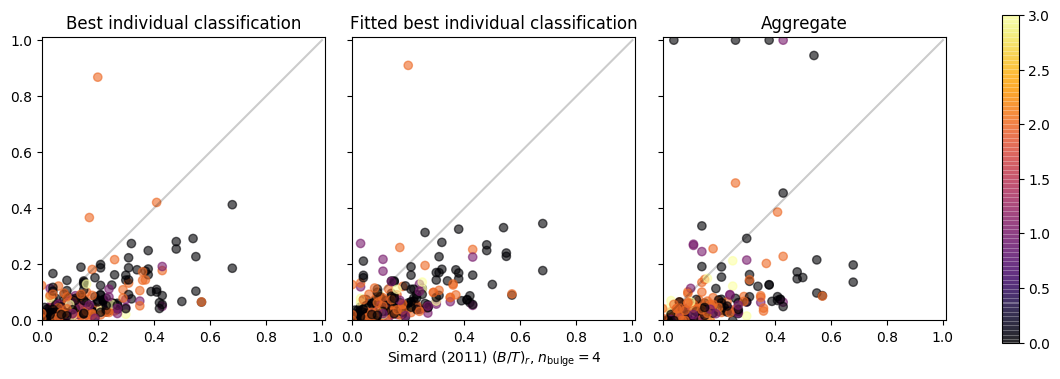

In [219]:
f, ax = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(12, 4), dpi=100)
for i, col in enumerate(cols):
  c = ax[i].scatter(
    comp_df['SIMARD'], comp_df[col], marker='o',
    alpha=0.6, c=comp_df['nspirals'].fillna(0), cmap='inferno', vmin=0, vmax=3
  )
  ax[i].set_xlim(0, 1.01)
  ax[i].set_ylim(0, 1.01)
  ax[i].add_line(plt.Line2D(*[[0, 1]]*2, color='k', alpha=0.2))
  ax[i].set_aspect('equal')
  ax[i].set_title(titles[i])
ax[1].set_xlabel('Simard (2011) $(B/T)_r$, $n_\mathrm{bulge}=4$')
plt.tight_layout()
plt.colorbar(c, ax=ax)

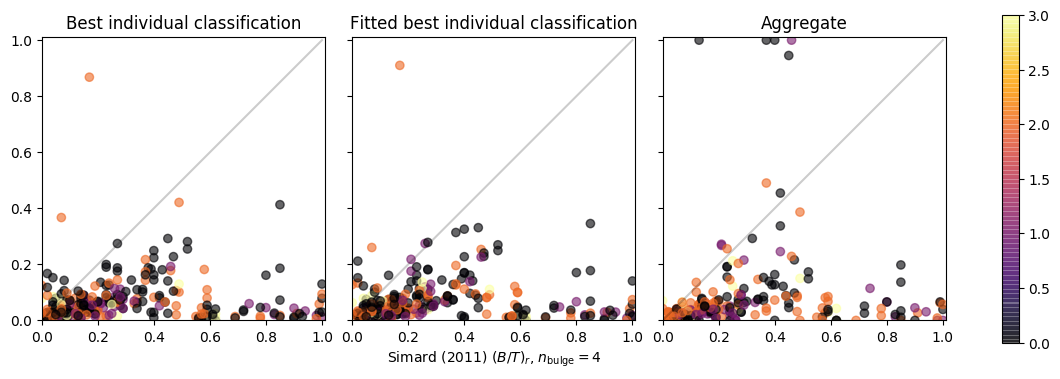

In [220]:
f, ax = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(12, 4), dpi=100)
for i, col in enumerate(cols):
  c = ax[i].scatter(
    comp_df['SIMARD_FREE'], comp_df[col], marker='o',
    alpha=0.6, c=comp_df['nspirals'].fillna(0), cmap='inferno', vmin=0, vmax=3
  )
  ax[i].set_xlim(0, 1.01)
  ax[i].set_ylim(0, 1.01)
  ax[i].add_line(plt.Line2D(*[[0, 1]]*2, color='k', alpha=0.2))
  ax[i].set_aspect('equal')
  ax[i].set_title(titles[i])
ax[1].set_xlabel('Simard (2011) $(B/T)_r$, $n_\mathrm{bulge}=4$')
plt.tight_layout()
plt.colorbar(c, ax=ax)

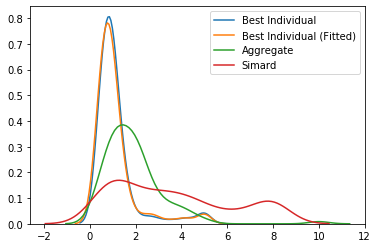

In [254]:
def get_bulge_n(model):
  return model['bulge'].get('n') if model['bulge'] is not None else np.nan

sns.kdeplot(bi_models.apply(get_bulge_n).dropna().rename('Best Individual'))
sns.kdeplot(fitted_bi_models.apply(get_bulge_n).dropna().rename('Best Individual (Fitted)'))
sns.kdeplot(fitted_agg_models.apply(get_bulge_n).dropna().rename('Aggregate'))
sns.kdeplot(simard_df_free['nb'].dropna().rename('Simard'))